In [2]:
import numpy as np
import cv2
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import models
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad, GradCAMElementWise
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入模型

In [3]:
model = models.resnet50(pretrained=True).eval().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 图像预处理

In [4]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(224),
                                     # transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 载入测试图片

In [5]:
img_path = '/public/home/msskx/shot5/data/CUB/train/201.normal/0026.png'

In [6]:
img_pil = Image.open(img_path)

In [7]:
#img_pil

In [8]:
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理

In [9]:
input_tensor.shape

torch.Size([1, 3, 224, 224])

## 选择可解释性分析方法

In [11]:
# GradCAM
from pytorch_grad_cam import GradCAM
target_layers = [model.layer4[-1]] # 要分析的层
targets = [ClassifierOutputTarget(232)] # 要分析的类别
cam = GradCAM(model=model, target_layers=target_layers)



## 生成Grad-CAM热力图

In [12]:
cam_map = cam(input_tensor=input_tensor, targets=targets)[0] # 不加平滑
# cam_map = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)[0] # 加平滑

In [13]:
cam_map.shape

(224, 224)

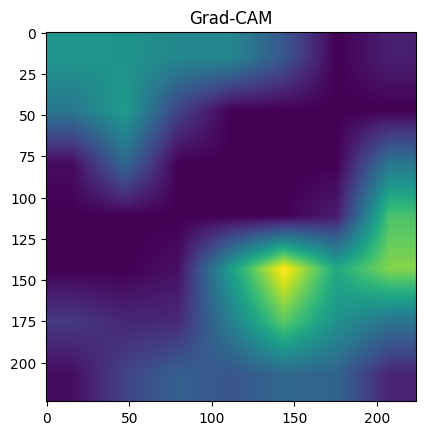

In [14]:
plt.imshow(cam_map)
plt.title('Grad-CAM')
plt.show()

In [15]:
import torchcam
from torchcam.utils import overlay_mask

result = overlay_mask(img_pil, Image.fromarray(cam_map), alpha=0.5) # alpha越小，原图越淡

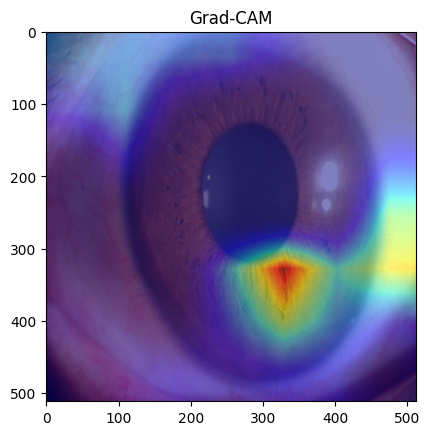

In [16]:
plt.imshow(result)
plt.title('Grad-CAM')
plt.show()

## Guided Backpropagation算法

In [19]:
# 初始化算法
gb_model = GuidedBackpropReLUModel(model=model,device='cuda')

In [20]:
# 生成 Guided Backpropagation热力图
gb_origin = gb_model(input_tensor, target_category=None)
gb_show = deprocess_image(gb_origin)

In [21]:
gb_show.shape

(224, 224, 3)

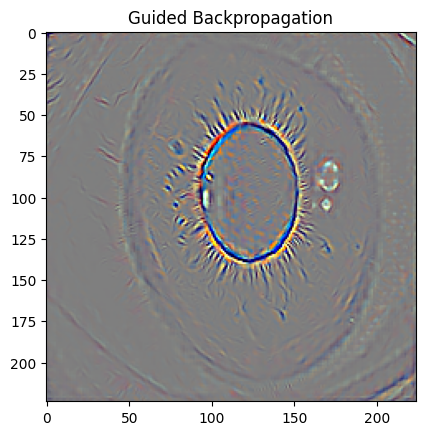

In [22]:
plt.imshow(gb_show)
plt.title('Guided Backpropagation')
plt.show()

## 将Grad-CAM热力图与Gudied Backpropagation热力图逐元素相乘

In [23]:
# Grad-CAM三通道热力图
cam_mask = cv2.merge([cam_map, cam_map, cam_map])

In [24]:
cam_mask.shape

(224, 224, 3)

In [25]:
# 逐元素相乘
guided_gradcam = deprocess_image(cam_mask * gb_origin)

In [26]:
guided_gradcam.shape

(224, 224, 3)

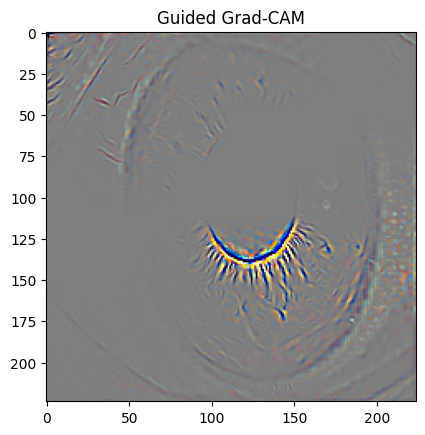

In [27]:
plt.imshow(guided_gradcam)
plt.title('Guided Grad-CAM')
plt.show()

In [28]:
cv2.imwrite('output/C1_guided_gradcam.jpg', guided_gradcam)

False